# Smart Travel App
## Notebook 4: Machine Learning - All Data

**Group 4, Project 4**  
Team: Dominique Villarreal, Enrique Garcia, Jose Santos  
Project Due Date: June 12, 2023


### Load Environment

In [50]:
#pip install seaborn
#pip install xgboost

In [1]:
import json
import os
import pandas as pd
import pprint as pp
import random
import requests
import time
import warnings
warnings.simplefilter("ignore")
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

### Import Data

In [2]:
# Import merged_df.csv from notebook 3
merged_file_path = '../G4_Project4/Resources/df_Extractions/merged_df.csv'
merged_df = pd.read_csv(merged_file_path)

# View df
merged_df.head(2)

,categories,name,rating,review_count,location,coordinates,city
0,"['Festivals', 'Arts & Crafts', 'Local Flavor']",Jackalope Arts,5.0,8,"{'address1': '5738 Olde Wadsworth Blvd', 'addr...","{'latitude': 39.800724136818026, 'longitude': ...",Denver
1,"['Venues & Event Spaces', 'Party & Event Plann...",Special Occasions Events,5.0,4,"{'address1': '3550 Federal Blvd', 'address2': ...","{'latitude': 39.76623, 'longitude': -105.02439}",Denver


In [3]:
# Process & Organize merged_df
# Remove columns we don't need for prediction process
columns_to_delete = ['location', 'coordinates']
merged_df.drop(columns_to_delete, axis=1, inplace=True)

# Arrange columns
merged_df = merged_df[['city','name', 'rating', 
                       'review_count', 'categories']]

# View updated df
merged_df.head(1)

,city,name,rating,review_count,categories
0,Denver,Jackalope Arts,5.0,8,"['Festivals', 'Arts & Crafts', 'Local Flavor']"


In [4]:
# Confirm merged_df information
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19627 entries, 0 to 19626
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          19627 non-null  object 
 1   name          19627 non-null  object 
 2   rating        19627 non-null  float64
 3   review_count  19627 non-null  int64  
 4   categories    19627 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 766.8+ KB


### Process Data

In [5]:
# Begin work for predicting city
# Create city_encoded_data df by copying merged_df
city_encoded_data = merged_df.copy()

# View df
city_encoded_data

,city,name,rating,review_count,categories
0,Denver,Jackalope Arts,5.0,8,"['Festivals', 'Arts & Crafts', 'Local Flavor']"
1,Denver,Special Occasions Events,5.0,4,"['Venues & Event Spaces', 'Party & Event Plann..."
2,Denver,Denver International Wine Festival,4.5,6,['Festivals']
3,Denver,"Denver Mineral, Fossil, Gem & Jewelry Show",4.5,10,['Festivals']
4,Denver,Colorado Festival of Horror,5.0,1,['Festivals']
...,...,...,...,...,...
19622,NewYork,Felice 56,4.0,94,"['Italian', 'Wine Bars']"
19623,NewYork,The Jeffrey Craft Beer & Bites,4.0,728,"['Bars', 'American (New)', 'Coffee & Tea']"
19624,NewYork,Saint Tuesday,4.0,30,"['Lounges', 'Speakeasies', 'Cocktail Bars']"
19625,NewYork,Harlem Nights Bar,4.0,185,"['Bars', 'Music Venues']"


In [6]:
# Explode the 'categories' column to create a row for each category listed in categories column
city_encoded_data['categories'] = city_encoded_data['categories'].apply(eval)
city_encoded_data = city_encoded_data.explode('categories')

# View df
city_encoded_data

,city,name,rating,review_count,categories
0,Denver,Jackalope Arts,5.0,8,Festivals
0,Denver,Jackalope Arts,5.0,8,Arts & Crafts
0,Denver,Jackalope Arts,5.0,8,Local Flavor
1,Denver,Special Occasions Events,5.0,4,Venues & Event Spaces
1,Denver,Special Occasions Events,5.0,4,Party & Event Planning
...,...,...,...,...,...
19625,NewYork,Harlem Nights Bar,4.0,185,Bars
19625,NewYork,Harlem Nights Bar,4.0,185,Music Venues
19626,NewYork,Cardiff Giant,4.0,56,Bars
19626,NewYork,Cardiff Giant,4.0,56,"Beer, Wine & Spirits"


In [7]:
# Categories - labelEncoder to encode categories and use in machine learning 
# Create a label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'categories' column
city_encoded_data['categories_encoded'] = label_encoder.fit_transform(city_encoded_data['categories'])

city_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44009 entries, 0 to 19626
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                44009 non-null  object 
 1   name                44009 non-null  object 
 2   rating              44009 non-null  float64
 3   review_count        44009 non-null  int64  
 4   categories          44008 non-null  object 
 5   categories_encoded  44009 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 2.4+ MB


In [8]:
# View table
city_encoded_data.head()

,city,name,rating,review_count,categories,categories_encoded
0,Denver,Jackalope Arts,5.0,8,Festivals,220
0,Denver,Jackalope Arts,5.0,8,Arts & Crafts,38
0,Denver,Jackalope Arts,5.0,8,Local Flavor,348
1,Denver,Special Occasions Events,5.0,4,Venues & Event Spaces,605
1,Denver,Special Occasions Events,5.0,4,Party & Event Planning,416


### Output Data

In [9]:
# Write out city_encoded_data to csv
pathname = '../G4_Project4/Resources/df_Extractions/city_encoded_data.csv'
city_encoded_data.to_csv(pathname, index=False)

In [10]:
# Create city_category_predict_df to avoid breaking city_encoded_data
city_category_predict_df = city_encoded_data[['city', 'name', 'rating', 'review_count', 'categories','categories_encoded']]

# View df
city_category_predict_df

,city,name,rating,review_count,categories,categories_encoded
0,Denver,Jackalope Arts,5.0,8,Festivals,220
0,Denver,Jackalope Arts,5.0,8,Arts & Crafts,38
0,Denver,Jackalope Arts,5.0,8,Local Flavor,348
1,Denver,Special Occasions Events,5.0,4,Venues & Event Spaces,605
1,Denver,Special Occasions Events,5.0,4,Party & Event Planning,416
...,...,...,...,...,...,...
19625,NewYork,Harlem Nights Bar,4.0,185,Bars,58
19625,NewYork,Harlem Nights Bar,4.0,185,Music Venues,384
19626,NewYork,Cardiff Giant,4.0,56,Bars,58
19626,NewYork,Cardiff Giant,4.0,56,"Beer, Wine & Spirits",70


### Random Forest ML Model - All Data

### RF Model Creation

In [51]:
# select X & y and reshape df
X = city_category_predict_df['categories_encoded'].values.reshape(-1, 1)
y = city_category_predict_df['city']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# View model
rf_model

RandomForestClassifier(random_state=42)

In [53]:
# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Evaluate the model on the test data
rf_accuracy = rf_model.score(X_test, y_test)
print("Accuracy:", rf_accuracy)

Accuracy: 0.5192001817768689


### RF Model (1,000 trees)

In [55]:
# Select X and y
X = city_category_predict_df[['categories_encoded', 'rating', 'review_count']].values
y = city_category_predict_df['city']

# Apply MinMaxScaler to scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Classifier
rf_1k_model = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42)

rf_1k_model

RandomForestClassifier(n_estimators=1000, random_state=42)

In [56]:
# Fit the model to the training data
rf_1k_model.fit(X_train, y_train)

# Evaluate the model on the test data
rf_1k_accuracy = rf_1k_model.score(X_test, y_test)
print("Accuracy:", rf_1k_accuracy)

Accuracy: 0.7676664394455806


### RF Model (10,000 trees)

In [57]:
# Select X and y
X = city_category_predict_df[['categories_encoded', 'rating', 'review_count']].values
y = city_category_predict_df['city']

# Apply MinMaxScaler to scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Classifier
rf_10k_model = RandomForestClassifier(n_estimators=10000, max_depth=None, random_state=42)

# View Model
rf_10k_model

RandomForestClassifier(n_estimators=10000, random_state=42)

In [58]:
# Fit the model to the training data
rf_10k_model.fit(X_train, y_train)

# Evaluate the model on the test data
rf_10k_accuracy = rf_10k_model.score(X_test, y_test)
print("Accuracy:", rf_10k_accuracy)

Accuracy: 0.7708475346512156


### XGBoost Model

In [60]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Select X and y
X = city_category_predict_df[['categories_encoded', 'rating', 'review_count']].values
y = city_category_predict_df['city']

# Apply MinMaxScaler to scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(booster='gbtree', n_estimators=1000, random_state=42)

# View the the XGBoost classifier
xgb_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [61]:
# Train the XGBoost classifier
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test data
xgb_accuracy = xgb_model.score(X_test, y_test)
print("Accuracy:", xgb_accuracy)

Accuracy: 0.7763008407180186


### Train & Test Our Chosen Model

In [62]:
xgb_model.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.8875507711534638

In [64]:
xgb_model.fit(X_test, y_test)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [65]:
xgb_model.score(X_test, y_test)

0.7763008407180186

In [66]:
# Calculate predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[1863  332  514]
 [ 297 2167  364]
 [ 313  149 2803]]


In [67]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      2709
           1       0.82      0.77      0.79      2828
           2       0.76      0.86      0.81      3265

    accuracy                           0.78      8802
   macro avg       0.78      0.77      0.77      8802
weighted avg       0.78      0.78      0.77      8802



In [68]:
# Get feature importances
feature_importances = model.feature_importances_
feature_names = ['categories_encoded', 'rating', 'review_count']
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print("Feature Importance:")
importance_df

Feature Importance:


,Feature,Importance
2,review_count,0.492702
0,categories_encoded,0.374743
1,rating,0.132556


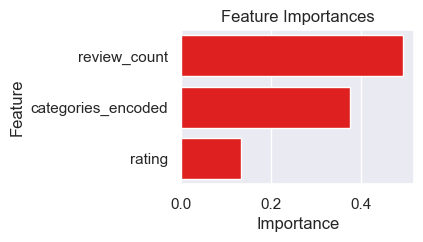

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme()

# Plot feature importances
plt.figure(figsize=(3, 2))
sns.barplot(data=importance_df, y='Feature', x='Importance', color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Predict the City

In [15]:
# Generate a random sample of 25 categories. This process is meant to mimic one person's 25-category selection
sample_categories = random.sample(list(city_category_predict_df['categories_encoded']), 25)

# Create DataFrame for random sample
sample_categories_encoded = pd.DataFrame({'categories_encoded': sample_categories})

# Include 'rating' and 'review_count' columns in the sample_categories_encoded DataFrame
matching_rows = city_category_predict_df['categories_encoded'].isin(sample_categories)
sample_categories_encoded['rating'] = city_category_predict_df.loc[matching_rows, 'rating'].values[:25]
sample_categories_encoded['review_count'] = city_category_predict_df.loc[matching_rows, 'review_count'].values[:25]

# Assign the readable category names based on the random sample of the 25 randomly selected categories above
category_names = city_category_predict_df.loc[matching_rows, 'categories'].unique()


In [16]:
# Print the readable categories being used to predict the city
print("Categories Used:")
for category in category_names:
    print(category)

Categories Used:
Breweries
Pizza
Coffee & Tea
Sports Bars
American (New)
Bars
Sandwiches
Delis
Cocktail Bars
British
Performing Arts
Rock Climbing
Dance Schools
Art Galleries
Boating
Community Service/Non-Profit
Farmers Market
Ramen
Dive Bars
Supernatural Readings
Cheesesteaks


In [17]:
# Predict the city based on the random group of 25 categories
prediction = model.predict(sample_categories_encoded)
predicted_city = prediction[0]
predicted_city

'NewYork'

### List Experiences Within Predicted City

In [18]:
# List top 3 experiences for each category within predicted city 
# Set to keep track of predicted cities and their activities
predicted_data = []

# Set to keep track of unique experiences
unique_experiences = set()

# Get the top activities for each sample category
for category in sample_categories:
    # Convert category back to its name
    category_name = city_category_predict_df.loc[city_category_predict_df['categories_encoded'] == category, 'categories'].iloc[0]

    filtered_activities = city_category_predict_df[(city_category_predict_df['city'] == predicted_city) & (city_category_predict_df['categories_encoded'] == category)]
    sorted_activities = filtered_activities.sort_values(['rating', 'review_count'], ascending=[False, False])
    top_activities = sorted_activities[['name', 'rating', 'review_count']].head(3)

    # Create a new activities_data list for each category iteration
    activities_data = []

    for _, activity in top_activities.iterrows():
        activity_name = activity['name']
        rating = activity['rating']
        review_count = activity['review_count']
                
        # Create a unique experience key
        experience_key = (category_name, predicted_city, activity_name)

        # Check if the experience is unique
        if experience_key not in unique_experiences:
            # Add the experience to the set of unique experiences
            unique_experiences.add(experience_key)

            # Append the predicted activity to the list
            activities_data.append({
                'Sample Category': category_name,
                'Predicted City': predicted_city,
                'Experience Name': activity_name,
                'Rating': rating,
                'Review Count': review_count
            })

    # Append the activities_data to the predicted_data list for each category
    predicted_data.extend(activities_data)

# Create a DataFrame from the predicted data
predicted_df = pd.DataFrame(predicted_data)

# Print the final predicted data DataFrame
print("Predicted user experiences based on predicted city:")
predicted_df

Predicted user experiences based on predicted city:


,Sample Category,Predicted City,Experience Name,Rating,Review Count
0,Rock Climbing,NewYork,Method Climbing,5.0,8
1,Rock Climbing,NewYork,The Gravity Vault - Montclair,5.0,7
2,Rock Climbing,NewYork,Central Rock Gym Manhattan,4.5,38
3,American (New),NewYork,Silver Light Tavern,5.0,105
4,Community Service/Non-Profit,NewYork,Long Island Meditation,5.0,25
5,Community Service/Non-Profit,NewYork,New York Irish Center,5.0,4
6,Community Service/Non-Profit,NewYork,Prospect Park,4.5,745
7,Pizza,NewYork,Scott's Pizza Tours,5.0,371
8,Pizza,NewYork,Mercato Roman Pizza,5.0,48
9,Delis,NewYork,111 Deli Stop Corp,5.0,29


### Output Predictions to csv

In [19]:
# Write the DataFrame to a CSV file
pathname = '../G4_Project4/Resources/Insights/predicted_df.csv'
predicted_df.to_csv(pathname, index=False)

### Proceed to G4_P4_Notebook5_MLvSelectedData